# Delta Hedging

This notebook compares delta hedging against simulated data with constant or stochastic volatility.

In [1]:
from collections import defaultdict
from dataclasses import dataclass
from datetime import date
from decimal import Decimal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyfeng as pf

from yabte.backtest import (
    ADFI_AVAILABLE_AT_CLOSE,
    ADFI_AVAILABLE_AT_OPEN,
    Book,
    CashTransaction,
    OHLCAsset,
    OrderSizeType,
    PositionalOrder,
    SimpleOrder,
    Strategy,
    StrategyRunner,
)
from yabte.utilities.simulation.geometric_brownian_motion import gbm_simulate_paths
from yabte.utilities.simulation.heston import heston_simulate_paths

## Black Scholes Asset & Simple Delta Hedge Strategy

In [5]:
# TODO: track call premium mtm valuation using constant / stochastic volatility


@dataclass(kw_only=True)
class BSMOption(OHLCAsset):
    """Black Scholes Model Option"""

    K: float
    exp: date
    r: float = 0
    divr: float = 0
    cp: int = 1

    def data_fields(self):
        dfs = super().data_fields()
        dfs.append(
            (
                "IVol",
                ADFI_AVAILABLE_AT_CLOSE | ADFI_AVAILABLE_AT_OPEN,
            )
        )
        return dfs

    def intraday_traded_price(self, asset_day_data, size) -> Decimal:
        ts = asset_day_data.name
        bsm_option = pf.Bsm(sigma=asset_day_data.IVol, intr=self.r, divr=self.divr)
        t = (self.exp - ts).days / 100
        price = bsm_option.price(self.K, asset_day_data.Close, t)
        return round(Decimal(price), self.price_round_dp)


class DeltaHedgingStrat(Strategy):
    def init(self):
        # capture some data for analysis
        self.metrics = defaultdict(dict)

    def on_open(self):
        data = self.data
        p = self.params
        ts = self.ts

        # buy option on t0
        if len(data) == 1:
            self.orders.append(SimpleOrder(asset_name="CO_ACME", size=1))

        # buy delta hedge shares
        t = (p.exp - ts).days / 100
        s = data.ACME.Open.iloc[-1]
        vol = data.iloc[-1].loc["ACME"].IVol
        bsm_option = pf.Bsm(sigma=vol, intr=p.r, divr=0)
        delta = bsm_option.delta(p.K, s, t)
        gamma = bsm_option.gamma(p.K, s, t)
        vega = bsm_option.vega(p.K, s, t)

        self.orders.append(
            PositionalOrder(
                asset_name="ACME", size=-1 * delta, size_type=OrderSizeType.QUANTITY
            )
        )

        self.metrics[ts]["delta"] = delta
        self.metrics[ts]["gamma"] = gamma
        self.metrics[ts]["vega"] = vega
        self.metrics[ts]["vol"] = vol
        self.metrics[ts]["price"] = s

## Constant Volatility

In [8]:
# gbm params
r = 0.05
vol = 0.2
s0 = 100
N = 101
T = N / 365

# simulate data
rng = np.random.default_rng(12345)  # for reproducibility
ix = pd.date_range(end="20221231", periods=N, freq="D")
p = gbm_simulate_paths(S0=s0, mu=r, sigma=vol, R=1, T=T, n_steps=N, n_sims=1, rng=rng)
df = pd.DataFrame(np.c_[p[:, :, 0], p[:, :, 0]], index=ix)
df.columns = pd.MultiIndex.from_tuples((("ACME", "Open"), ("ACME", "Close")))

# add constant vol to data
df.loc[:, ("ACME", "IVol")] = vol

# assets
assets = [
    OHLCAsset(name="ACME", denom="USD", quantity_round_dp=6),
    BSMOption(name="CO_ACME", data_label="ACME", K=s0, exp=ix[-1], r=r),
]

# run simulation
book = Book(name="Main", cash="0", rate=0.05 / 100)
sr = StrategyRunner(
    data=df,
    assets=assets,
    strategies=[DeltaHedgingStrat()],
    books=[book],
)
srr = sr.run(
    {
        "r": r,
        "vol": vol,
        "exp": ix[-1],
        "K": s0,
    }
)
metrics = pd.DataFrame.from_dict(srr.strategies[0].metrics, orient="index").reindex(
    srr.book_history.index
)

/home/pyvenvs/scratch-3.11/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:301: RuntimeWarning: overflow encountered in scalar power
  return np.exp(-x**2/2.0) / _norm_pdf_C


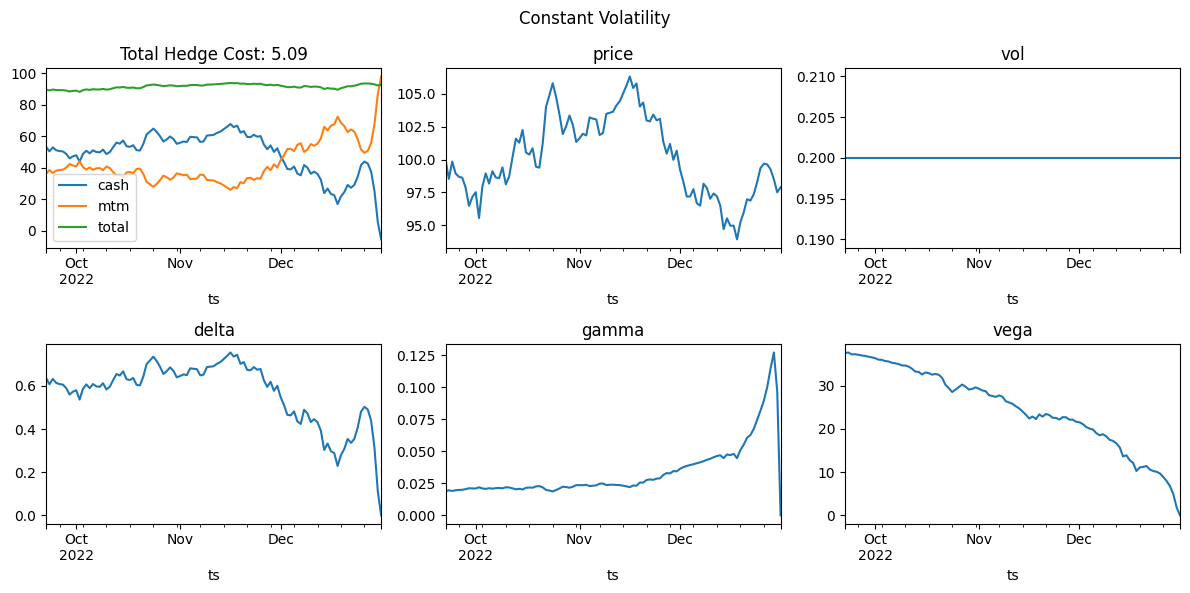

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(3 * 4, 2 * 3))
fig.suptitle("Constant Volatility")
thc = srr.transaction_history[1:].total.sum()
srr.book_history.Main.plot(ax=axs[0][0], title=f"Total Hedge Cost: {thc:.2f}")
metrics.price.plot(title="price", ax=axs[0][1])
metrics.vol.plot(title="vol", ax=axs[0][2])
metrics.delta.plot(title="delta", ax=axs[1][0])
metrics.gamma.plot(title="gamma", ax=axs[1][1])
metrics.vega.plot(title="vega", ax=axs[1][2])
fig.tight_layout()

## Stochastic Volatility

In [11]:
# gbm params
r = 0.05
vol = 0.2
s0 = 100
N = 101
T = N / 365


kappa = 4
theta = 0.02
v0 = 0.02
sigma = 0.9
R = 0.9


# simulate data
rng = np.random.default_rng(12345)  # for reproducibility
ix = pd.date_range(end="20221231", periods=N, freq="D")
p, vol = heston_simulate_paths(
    S0=s0,
    v0=v0,
    mu=r,
    kappa=kappa,
    theta=theta,
    xi=sigma,
    R=np.array([[1, R], [R, 1]]),
    T=T,
    n_steps=N,
    n_sims=1,
    rng=rng,
)

df = pd.DataFrame(np.c_[p[:, 0], p[:, 0]], index=ix)
df.columns = pd.MultiIndex.from_tuples((("ACME", "Open"), ("ACME", "Close")))

# add constant vol to data
df.loc[:, ("ACME", "IVol")] = vol

# assets
assets = [
    OHLCAsset(name="ACME", denom="USD", quantity_round_dp=6),
    BSMOption(name="CO_ACME", data_label="ACME", K=s0, exp=ix[-1], r=r),
]

# run simulation
book = Book(name="Main", cash="0", rate=0.05 / 100)
srr = StrategyRunner(
    data=df,
    assets=assets,
    strategies=[DeltaHedgingStrat()],
    books=[book],
)
srr = sr.run(
    {
        "r": r,
        "vol": vol,
        "exp": ix[-1],
        "K": s0,
    }
)
metrics = pd.DataFrame.from_dict(srr.strategies[0].metrics, orient="index").reindex(
    srr.book_history.index
)

/home/pyvenvs/scratch-3.11/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:301: RuntimeWarning: overflow encountered in scalar power
  return np.exp(-x**2/2.0) / _norm_pdf_C


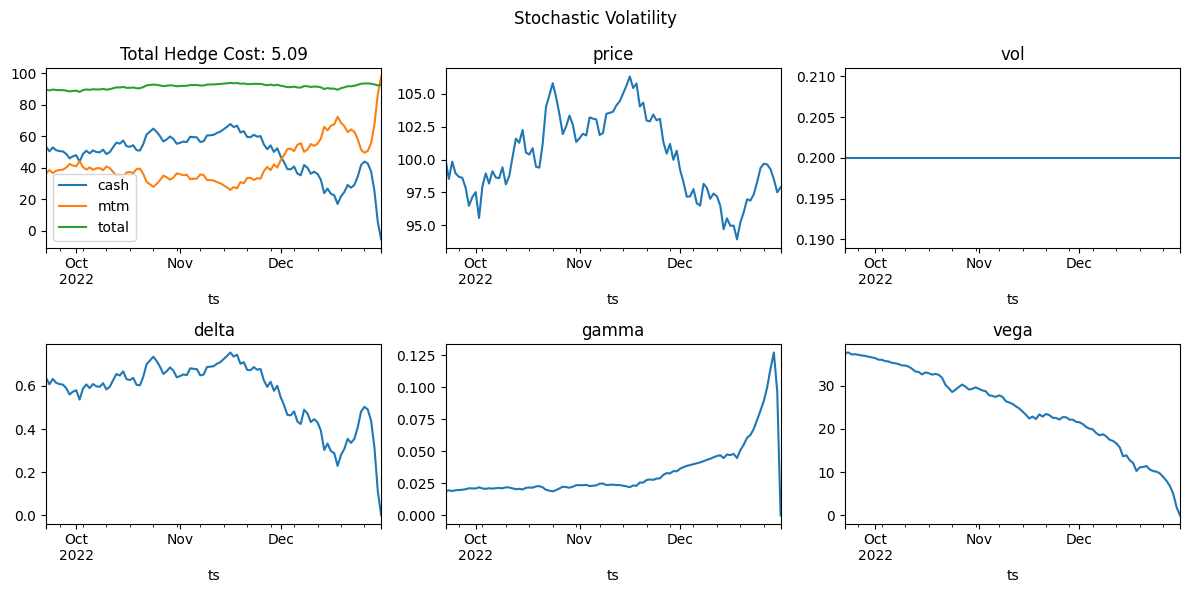

In [12]:
fig, axs = plt.subplots(2, 3, figsize=(3 * 4, 2 * 3))
fig.suptitle("Stochastic Volatility")
thc = srr.transaction_history[1:].total.sum()
srr.book_history.Main.plot(ax=axs[0][0], title=f"Total Hedge Cost: {thc:.2f}")
metrics.price.plot(title="price", ax=axs[0][1])
metrics.vol.plot(title="vol", ax=axs[0][2])
metrics.delta.plot(title="delta", ax=axs[1][0])
metrics.gamma.plot(title="gamma", ax=axs[1][1])
metrics.vega.plot(title="vega", ax=axs[1][2])
fig.tight_layout()

## Transactions

In [13]:
with pd.option_context("display.max_rows", None):
    display(srr.transaction_history.head(20))

,ts,total,desc,quantity,price,asset_name,order_label,book
0,2022-09-22,-10.4500,buy CO_ACME,1.00,10.45,CO_ACME,NaN,Main
1,2022-09-22,63.68310000,sell ACME,-0.636831,100.00,ACME,NaN,Main
2,2022-09-22,0.027,interest payment on cash 53.23,NaN,NaN,NaN,NaN,Main
3,2022-09-23,-62.74695843,buy ACME,0.636831,98.53,ACME,NaN,Main
4,2022-09-23,59.89283992,sell ACME,-0.607864,98.53,ACME,NaN,Main
5,2022-09-23,0.025,interest payment on cash 50.41,NaN,NaN,NaN,NaN,Main
6,2022-09-24,-60.69522040,buy ACME,0.607864,99.85,ACME,NaN,Main
7,2022-09-24,63.16890430,sell ACME,-0.632638,99.85,ACME,NaN,Main
8,2022-09-24,0.026,interest payment on cash 52.90,NaN,NaN,NaN,NaN,Main
9,2022-09-25,-62.59953010,buy ACME,0.632638,98.95,ACME,NaN,Main
